In [1]:
#导入相应的包
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

import os
import sys
from collections import Counter
import re

#import tensorflow.contrib.keras as kr
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from torchtext import data
import jieba

import cv2
import os

from torch.autograd import Variable
import tensorwatch as tw
import torchvision.models

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
torch.set_printoptions(precision=15)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
np.set_printoptions(threshold=np.inf)

import time

# import seaborn as sns
# # seaborn中文乱码解决方案
# from matplotlib.font_manager import FontProperties
# myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
# sns.set(font=myfont.get_name())

## 路径

In [2]:
video_path = 'C:/Users/wuxun/Desktop/Data/feat_dat/'
image_path = 'C:/Users/wuxun/Desktop/Data/image/'#存储到image文件夹中
clip_path = 'C:/Users/wuxun/Desktop/Data/clip/'
text_dir = 'C:/Users/wuxun/Desktop/Data/clear_text.txt'
vocab_dir = 'C:/Users/wuxun/Desktop/Data/vocab.txt'
train_path = 'C:/Users/wuxun/Desktop/Data/training/training.txt'
val_path = 'C:/Users/wuxun/Desktop/Data/validation/validation.txt'
csv_path = 'D:/csv/'
save_path = 'C:/Users/wuxun/Desktop/Data/save_model/new_model_for_1500/'

## 参数定义

In [3]:
#固定随机数种子
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# 数据处理

In [4]:
 def read_file(filename):

    """读取文件数据"""
    
    contents = []
    with open(filename) as f:
        for line in f:
            contents.append(re.split('[, \n.]',line))
    return contents

In [5]:
def build_vocab(text_dir, vocab_dir, vocab_size=3000):

    """根据训练集构建词汇表，存储"""
    data_train = read_file(text_dir)
    all_data = []
    for content in data_train:
        for k in content:
            if len(k)!=0:
                all_data.append(k)
    print(all_data)
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open(vocab_dir, mode='w').write('\n'.join(words) + '\n')

In [6]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [7]:
def to_words(content, words):

    """将id表示的内容转换为文字"""

    return ''.join(words[x] for x in content)

In [8]:
def get_dict(path, csv_path):
    '''
    获得最终的数据集
    path:文本数据集
    csv_path
    '''
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    source_csv=[]
    target_csv=[]
    fake_time_list=[]
    source_time_list=[]
    target_time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            source = List[4]
            target = List[5]
            fake_time = (List[7].split('_'))
            fake_time_l=int(fake_time[0])
            fake_time_r=int(fake_time[1])
            fake_time_list.append([fake_time_l, fake_time_r])
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点
            source = source.split('_')
            target = target.split('_')
            
            source_time = (float(source[0])+float(source[1]))//2
            source_time_list.append([float(source[0]),float(source[1])])
            source_frame_num = int(source_time/time_length*500)
            source_frame = frame_sum.loc[source_frame_num]
            source_csv.append([source_frame])
            
            target_time = (float(target[0])+float(target[1]))//2
            target_time_list.append([float(target[0]),float(target[1])])
            target_frame_num = int(target_time/time_length*500)
            target_frame = frame_sum.loc[target_frame_num]
            target_csv.append([target_frame])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)
            
    print(len(batch_seq),len(source_csv),len(target_csv))
    
    return batch_seq, source_csv, target_csv, source_time_list, target_time_list

# 读取数据

In [10]:
#训练集
x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train = get_dict(train_path, csv_path)

1548 1548 1548


In [11]:
#验证集
x_batch_val, x_csv_val, y_csv_val, source_list_val, target_list_val = get_dict(val_path, csv_path)

523 523 523


## 绘制数据分布

In [55]:
begin_time_list = offset_list

In [56]:
print(type(begin_time_list[0]))
print(len(begin_time_list))

<class 'numpy.float64'>
523


In [57]:
Max_v=-1;
Min_v=2000
for i in range(len(begin_time_list)):
    if begin_time_list[i] > Max_v:
        Max_v=begin_time_list[i]
    if begin_time_list[i] < Min_v:
        Min_v=begin_time_list[i]

In [58]:
print(Max_v, Min_v)
num_block = ((Max_v - Min_v)/10)
print(num_block)

423.8582592010498 -157.7686767578125
58.16269359588623


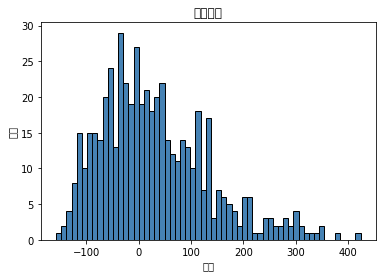

In [59]:
plt.hist(x = begin_time_list, # 指定绘图数据
         bins = 59, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('偏差')
plt.ylabel('频数')
# 添加标题
plt.title('偏差分布')
# 显示图形
plt.show()

In [126]:
# # Pandas模块绘制直方图和核密度图
# # 读入数据
# Titanic = pd.DataFrame(begin_time_list)
# # 绘制直方图
# Titanic.plot(kind = 'hist', bins = 65, color = 'steelblue', edgecolor = 'black', normed = True, label = '直方图')
# # 添加x轴和y轴标签
# plt.xlabel('%killbgscripts始时间')
# plt.ylabel('核密度值')
# # 添加标题
# plt.title('乘客年龄分布')
# # 显示图例
# plt.legend()
# # 显示图形
# plt.show()
# plt.savefig('C:/Users/wuxun/Desktop/resualt.jpg')

In [127]:
# middle_model = LSTM_CNN()
# change_model = Change()
# middle_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_64_dim_params.pkl'))
# change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/the_first_model/the_first_model_epoch_197_batchsize1_params.pkl'))

# 基础模型

### 模型定义

In [11]:
batch_size = 64

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, mean=0, std=0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data)
        m.bias.data.fill_(0)

In [13]:
# 定义LSTM的结构
class LSTM_CNN(nn.Module):
    
    def __init__(self):
        super(LSTM_CNN, self).__init__()
        
        self.embedding = nn.Embedding(5000, 64)
        self.rnn = nn.LSTM(input_size=64, hidden_size=256, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(512,128), nn.Dropout(0.8), nn.ReLU())        
        
        self.conv1 = torch.nn.Conv1d(512, 256, kernel_size=1, stride=1)
        self.conv2 = torch.nn.Conv1d(256, 128, kernel_size=1, stride=1)

        self.fc1=torch.nn.Linear(512,128)
        self.fc1_drop=torch.nn.Dropout(p=0.4)
        self.fc2=torch.nn.Linear(128, 64)
        
        #特征融合
        self.final_fc = nn.Linear(in_features=256, out_features=128)
        # Initializing weights
        self.apply(weights_init)
        
        
    def cnnout(self, x2):
        x2 = x2.permute(0, 2, 1)
        out1 = self.conv1(x2)
        out1_norm = F.normalize(out1, p=2, dim = 1)
        out2 = self.conv2(out1_norm)
        out2_norm = F.normalize(out2, p=2, dim = 1)
        return out2_norm
        
        
    def forward(self, x1, x2): 
        if x1.shape[0]!=2:
            #lstm
            x = self.embedding(x1)
            x,_ = self.rnn(x)
            x = F.dropout(x, p=0.8)
            lstm_output = self.f1(x[:,-1,:])
            #cnn
            cnn_out=self.cnnout(x2)
            #concat
            cnn_out = cnn_out.squeeze(2)
            output = torch.cat((lstm_output, cnn_out), 1)
            output = self.final_fc(output)
            return output
        else:
            cnn_out=self.cnnout(x2)
            cnn_out = cnn_out.squeeze(2)
            return cnn_out

### 生成批次数据

In [14]:
def write_resualt_file(path, line):
    with open(path, 'a') as f:
        f.write(line+'\n')

In [15]:
def batch_iter(x_batch, x_csv, y_csv, source_list, target_list, batch_size=32):

    """
    生成批次数据
    """

    data_len = x_batch.shape[0]
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_batch_shuffle = x_batch[indices]
    x_csv_shuffle =np.array(x_csv)[indices]
    y_csv_shuffle = np.array(y_csv)[indices]
    source_list = np.array(source_list)[indices]
    target_list = np.array(target_list)[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_batch_shuffle[start_id:end_id], x_csv_shuffle[start_id:end_id], y_csv_shuffle[start_id:end_id], source_list[start_id:end_id], target_list[start_id:end_id]

In [16]:
#存储loss数据
train_loss_list = []
val_loss_list = []

### 训练函数

In [17]:
def train(inital_epoch):
    model = LSTM_CNN()
    model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/new_model_for_1500/529_params.pkl'))
    Loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    T=Variable(torch.FloatTensor([[1.0,1.0],[1.0,1.0]]))
    best_val_loss = 1000000
    print("train begin......")
    
    for epoch in range(300):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size)
        train_loss_sum = 0
        train_loss_avg = 0
        count = 0
        begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch))
                x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                y = Variable(torch.FloatTensor(np.array(y_csv)))
                pred_y = model(x1, x2)
                negtive = model(T, x2)
                postive = model(T, y)
                loss_reg = Loss(pred_y, postive, negtive)
                train_loss_sum += loss_reg
                optimizer.zero_grad()
                loss_reg.backward()
                optimizer.step()
        
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        train_loss_avg = train_loss_sum / count
        line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f |' % (inital_epoch + epoch, train_loss_avg))
        print(line)
        write_resualt_file(save_path+'resualt.txt', line)
        train_loss_list.append(train_loss_sum)

        if (epoch+1)%5 == 0:
            print("进行验证.....")
            begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size)
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    y = Variable(torch.FloatTensor(np.array(y_csv)))
                    pred_y = model(x1, x2)
                    negtive = model(T, x2)
                    postive = model(T, y)
                    loss_reg = Loss(pred_y, postive, negtive)
                    val_loss_sum += loss_reg
                    optimizer.zero_grad()
                    loss_reg.backward()
                    optimizer.step()
            
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            val_loss_avg = val_loss_sum / count
            line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f |' % (inital_epoch + epoch, val_loss_avg))
            print(line)
            write_resualt_file(save_path+'resualt.txt', line)
            val_loss_list.append(val_loss_sum)   
            torch.save(model.state_dict(), save_path+str(inital_epoch + epoch)+'_params.pkl')
            if val_loss_sum < best_val_loss:
                #torch.save(model.state_dict(), save_path+str(inital_epoch + epoch)+'_params.pkl')
                best_val_loss = val_loss_sum
                print("model save!")

### 训练基础模型

In [18]:
# train(529)

### 绘制Loss曲线

In [17]:
def draw(train_loss_list, val_loss_list):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(val_loss_list))
    plt.subplot(2, 1, 1)
    plt.plot(x1, train_loss_list[:len(train_loss_list)], 'o-')
    plt.title('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.subplot(2, 1, 2)
    plt.plot(x2,val_loss_list[:len(val_loss_list)] , '.-')
    plt.xlabel('Val loss vs. epoches')
    plt.ylabel('Val loss')
    plt.show()

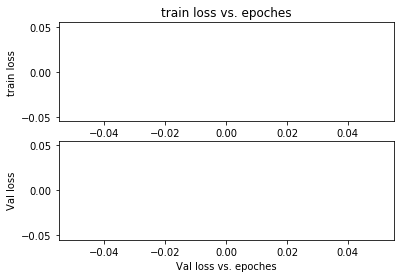

In [20]:
draw(train_loss_list, val_loss_list)

# 回归模型

### 回归模型定义

In [18]:
#超参数lambda
lamba = 0.1
batch_size2 = 64

### TCN定义

In [12]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        其实这就是一个裁剪的模块，裁剪多出来的padding
        """
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        """
        相当于一个Residual block

        :param n_inputs: int, 输入通道数
        :param n_outputs: int, 输出通道数
        :param kernel_size: int, 卷积核尺寸
        :param stride: int, 步长，一般为1
        :param dilation: int, 膨胀系数
        :param padding: int, 填充系数
        :param dropout: float, dropout比率
        """
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
        self.chomp1 = Chomp1d(padding)  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)  #  裁剪掉多出来的padding部分，维持输出时间步为seq_len
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        """
        参数初始化

        :return:
        """
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        """
        :param x: size of (Batch, input_channel, seq_len)
        :return:
        """
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        """
        TCN，目前paper给出的TCN结构很好的支持每个时刻为一个数的情况，即sequence结构，
        对于每个时刻为一个向量这种一维结构，勉强可以把向量拆成若干该时刻的输入通道，
        对于每个时刻为一个矩阵或更高维图像的情况，就不太好办。

        :param num_inputs: int， 输入通道数
        :param num_channels: list，每层的hidden_channel数，例如[25,25,25,25]表示有4个隐层，每层hidden_channel数为25
        :param kernel_size: int, 卷积核尺寸
        :param dropout: float, drop_out比率
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i   # 膨胀系数：1，2，4，8……
            in_channels = num_inputs if i == 0 else num_channels[i-1]  # 确定每一层的输入通道数
            out_channels = num_channels[i]  # 确定每一层的输出通道数
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        输入x的结构不同于RNN，一般RNN的size为(Batch, seq_len, channels)或者(seq_len, Batch, channels)，
        这里把seq_len放在channels后面，把所有时间步的数据拼起来，当做Conv1d的输入尺寸，实现卷积跨时间步的操作，
        很巧妙的设计。
        
        :param x: size of (Batch, input_channel, seq_len)
        :return: size of (Batch, output_channel, seq_len)
        """
        return self.network(x)


In [19]:
# # 定义LSTM的结构
# class Change(nn.Module):
#     def __init__(self):
#         super(Change, self).__init__()
#         self.score_fc = torch.nn.Conv2d(128, 3, kernel_size=1, stride=1)
#         self.apply(weights_init)
#     def forward(self, x):
#         output = x
#         #特征转换
#         output_expand = output.expand([batch_size2, batch_size2, 128])
#         output_expand = output_expand.unsqueeze(0).permute(0, 3, 1, 2)
#         score = self.score_fc(output_expand).squeeze(0)
#         return score

### 回归模型二

In [20]:
# 定义LSTM的结构
class Change(nn.Module):
    def __init__(self):
        super(Change, self).__init__()
        #特征融合
        self.score_fc = torch.nn.Conv1d(128, 2, kernel_size=1, stride=1)
#         self.score_fc2 = torch.nn.Conv1d(64, 2, kernel_size=1, stride=1)
        self.apply(weights_init)

    def forward(self, x):
        output = x#[batch_size2, 128]
        output = output.unsqueeze(2)
        score = self.score_fc(output)
#         score = self.score_fc2(score)
        offset_pred = score.squeeze(2)
        return offset_pred

#### 路径定义

In [21]:
save_path2 = 'C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2无alignment/'
save_resualt_path2 = 'C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2无alignment/resualt.txt'
save_path2_with_align = 'C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2有alignment/'
save_resualt_path2_with_align = 'C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2有alignment/resualt.txt'

In [22]:
train_loss_2_list=[]
val_loss_2_list=[]

### 训练函数

In [31]:
def train_for_Change_model_3(resualt_path, model_save_path, inital_epoch):
    change_model = Change()
    model = LSTM_CNN()
    model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/new_model_for_1500/494_params.pkl'))
    
    #冻结基础模型参数
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    #change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2无alignment/batchsize_is_1_19.pkl'))
    optimizer = optim.Adam(change_model.parameters(), lr = 0.001)
    best_val_loss_2 = 1000000
    print("train begin......")
    for epoch in range(1000):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size2)
        count = 0
        train_loss_sum = 0
        begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size2:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch))
                x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                source_time = Variable(torch.FloatTensor(np.array(source_time)))
                target_time = Variable(torch.FloatTensor(np.array(target_time)))
                pred = model(x1, x2)
                pred2 = change_model(pred)
            
                Loss = torch.abs(pred2 - target_time).mean()
                
                train_loss_sum += Loss
                optimizer.zero_grad()
                Loss.backward()
                optimizer.step()
                
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())        
        line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f |' % (inital_epoch + epoch, train_loss_sum / (count)))
        print(line)
        write_resualt_file(resualt_path, line)
        train_loss_2_list.append(train_loss_sum / count)

        if (epoch+1)%5==0:
            print("进行验证.......")
            begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size2)
            count = 0
            val_loss_sum = 0
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size2:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    source_time = Variable(torch.FloatTensor(np.array(source_time)))
                    target_time = Variable(torch.FloatTensor(np.array(target_time)))
                    pred = model(x1, x2)
                    pred2 = change_model(pred)
                    
                    Loss = torch.abs(pred2 - target_time).mean()

                    val_loss_sum += Loss
                    optimizer.zero_grad()
                    Loss.backward()
                    optimizer.step()
            
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
            line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f |' % (inital_epoch + epoch, val_loss_sum / (count)))
            print(line)
            write_resualt_file(resualt_path, line)
            val_loss_2_list.append(val_loss_sum / count) 
            #torch.save(change_model.state_dict(), model_save_path + 'batchsize_is_64_the_first_model_300_' + str(inital_epoch + epoch)+'.pkl')
            if (val_loss_sum / count ) < best_val_loss_2:
                best_val_loss_2 = val_loss_sum / count
                print("model save!")

In [32]:
# def train_2(resualt_path, model_save_path, inital_epoch):
#     change_model = Change()
#     model = LSTM_CNN()
#     model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/new_model_for_1500/249_params.pkl'))
    
#     #冻结基础模型参数
#     model.eval()
#     for param in model.parameters():
#         param.requires_grad = False
    
#     #change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/with_alignmentloss_batch_size_32/操作放在train中/The_second_model_epoch_1055_lr0.01_batchsize32_params.pkl'))
#     optimizer = optim.Adam(change_model.parameters(), lr = 0.001)#0.001
#     best_val_loss_2 = 1000000
#     print("train begin......")
#     for epoch in range(1000):
#         batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size2)
#         count = 0
#         train_loss_sum = 0
#         train_alignmentloss_sum = 0
#         train_regloss_sum =0
#         begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
#         for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
#             if x_csv.shape[0]==batch_size2:
#                 count += 1
#                 x1 = Variable(torch.LongTensor(x_batch))
#                 x2 = Variable(torch.FloatTensor(np.array(x_csv)))
#                 source_time = Variable(torch.FloatTensor(np.array(source_time)))
#                 target_time = Variable(torch.FloatTensor(np.array(target_time)))
#                 pred = model(x1, x2)
#                 score = change_model(pred)
#                 #write_resualt_file(resualt_path, str(score))
                
#                 #特征变换
#                 alignment_mat = score[0]
#                 l_mat = score[1]
#                 r_mat = score[2]

#                 I = torch.eye(batch_size2)
#                 allone = torch.ones(batch_size2, batch_size2)
#                 mask = allone - 2 * I

#                 l_reg = torch.mm(l_mat * I, torch.ones(batch_size2, 1))
#                 r_reg = torch.mm(r_mat * I, torch.ones(batch_size2, 1))
#                 offset_pred = torch.cat([l_reg, r_reg], 1)

#                 loss_mat = torch.log(allone + torch.exp(mask * score[0]))

#                 para = I + 1.0 / batch_size2 * allone
#                 loss_mat = loss_mat * para
#                 loss_alignment = loss_mat.mean()
#                 loss_reg = torch.abs(offset_pred - target_time).mean()
                
#                 #最终的损失函数
#                 Loss = loss_reg * lamba + loss_alignment
                
#                 train_regloss_sum += loss_reg
#                 train_loss_sum += Loss
#                 train_alignmentloss_sum += loss_alignment
#                 optimizer.zero_grad()
#                 Loss.backward()
#                 optimizer.step()
                
#         current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())        
#         line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f | loss_align: %.6f | loss_reg: %.6f' % (epoch, train_loss_sum / (count), train_alignmentloss_sum / (count), train_regloss_sum / (count)))
#         print(line)
#         write_resualt_file(resualt_path, line)
#         train_loss_2_list.append(train_loss_sum / count)

#         if (epoch+1)%5==0:
#             print("进行验证.......")
#             begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
#             batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size2)
#             count = 0
#             val_loss_sum = 0
#             val_alignmentloss_sum =0
#             val_regloss_sum =0
#             for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
#                 if x_csv.shape[0]==batch_size2:
#                     count += 1
#                     x1 = Variable(torch.LongTensor(x_batch))
#                     x2 = Variable(torch.FloatTensor(np.array(x_csv)))
#                     source_time = Variable(torch.FloatTensor(np.array(source_time)))
#                     target_time = Variable(torch.FloatTensor(np.array(target_time)))
#                     pred = model(x1, x2)
#                     score = change_model(pred)
                    
#                     #特征变换
#                     alignment_mat = score[0]
#                     l_mat = score[1]
#                     r_mat = score[2]

#                     I = torch.eye(batch_size2)
#                     allone = torch.ones(batch_size2, batch_size2)
#                     mask = allone - 2 * I

#                     l_reg = torch.mm(l_mat * I, torch.ones(batch_size2, 1))
#                     r_reg = torch.mm(r_mat * I, torch.ones(batch_size2, 1))
#                     offset_pred = torch.cat([l_reg, r_reg], 1)
#                     loss_mat = torch.log(allone + torch.exp(mask * score[0]))

#                     para = I + 1.0 / batch_size2 * allone
#                     loss_mat = loss_mat * para
#                     loss_alignment = loss_mat.mean()
#                     loss_reg = torch.abs(offset_pred - target_time).mean()
                    
#                     #模型最终的loss
#                     Loss = loss_reg * lamba + loss_alignment
                    
#                     val_alignmentloss_sum += loss_alignment
#                     val_regloss_sum += loss_reg
#                     val_loss_sum += Loss
#                     optimizer.zero_grad()
#                     Loss.backward()
#                     optimizer.step()
            
#             current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
#             line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f | loss_align: %.6f | loss_reg: %.6f' % (epoch, val_loss_sum / (count), val_alignmentloss_sum / (count), val_regloss_sum / (count)))
#             print(line)
#             write_resualt_file(resualt_path, line)
#             val_loss_2_list.append(val_loss_sum / count) 
#             torch.save(change_model.state_dict(), model_save_path + 'epoch_'+str(inital_epoch + epoch)+'.pkl')
#             if (val_loss_sum / count ) < best_val_loss_2:
#                 best_val_loss_2 = val_loss_sum / count
#                 print("model save!")

### 训练回归模型

In [33]:
train_for_Change_model_3(save_resualt_path2, save_path2, 0)

train begin......
2020-08-16 06:30:18 | 2020-08-16 06:30:23 | Epoch:   0 | Loss: 135.247025 |
2020-08-16 06:30:23 | 2020-08-16 06:30:28 | Epoch:   1 | Loss: 93.701881 |
2020-08-16 06:30:28 | 2020-08-16 06:30:33 | Epoch:   2 | Loss: 93.794548 |
2020-08-16 06:30:33 | 2020-08-16 06:30:39 | Epoch:   3 | Loss: 93.548981 |
2020-08-16 06:30:39 | 2020-08-16 06:30:45 | Epoch:   4 | Loss: 93.203804 |
进行验证.......
2020-08-16 06:30:45 | 2020-08-16 06:30:47 | Epoch:   4 | Loss: 98.868355 |
model save!
2020-08-16 06:30:47 | 2020-08-16 06:30:53 | Epoch:   5 | Loss: 92.320641 |
2020-08-16 06:30:53 | 2020-08-16 06:31:00 | Epoch:   6 | Loss: 91.992134 |
2020-08-16 06:31:00 | 2020-08-16 06:31:06 | Epoch:   7 | Loss: 92.577980 |
2020-08-16 06:31:06 | 2020-08-16 06:31:12 | Epoch:   8 | Loss: 92.759796 |
2020-08-16 06:31:12 | 2020-08-16 06:31:18 | Epoch:   9 | Loss: 92.581543 |
进行验证.......
2020-08-16 06:31:18 | 2020-08-16 06:31:20 | Epoch:   9 | Loss: 97.876205 |
model save!
2020-08-16 06:31:20 | 2020-08-16 

2020-08-16 06:49:22 | 2020-08-16 06:49:28 | Epoch: 175 | Loss: 91.803062 |
2020-08-16 06:49:28 | 2020-08-16 06:49:34 | Epoch: 176 | Loss: 91.118065 |
2020-08-16 06:49:34 | 2020-08-16 06:49:40 | Epoch: 177 | Loss: 90.746796 |
2020-08-16 06:49:40 | 2020-08-16 06:49:46 | Epoch: 178 | Loss: 92.209961 |
2020-08-16 06:49:46 | 2020-08-16 06:49:52 | Epoch: 179 | Loss: 92.550087 |
进行验证.......
2020-08-16 06:49:52 | 2020-08-16 06:49:54 | Epoch: 179 | Loss: 96.696190 |
2020-08-16 06:49:54 | 2020-08-16 06:50:00 | Epoch: 180 | Loss: 91.899040 |
2020-08-16 06:50:00 | 2020-08-16 06:50:06 | Epoch: 181 | Loss: 91.965706 |
2020-08-16 06:50:06 | 2020-08-16 06:50:12 | Epoch: 182 | Loss: 91.646057 |
2020-08-16 06:50:13 | 2020-08-16 06:50:19 | Epoch: 183 | Loss: 90.941315 |
2020-08-16 06:50:19 | 2020-08-16 06:50:25 | Epoch: 184 | Loss: 92.341805 |
进行验证.......
2020-08-16 06:50:25 | 2020-08-16 06:50:26 | Epoch: 184 | Loss: 96.005219 |
2020-08-16 06:50:26 | 2020-08-16 06:50:33 | Epoch: 185 | Loss: 92.226349 |
2

2020-08-16 07:08:36 | 2020-08-16 07:08:42 | Epoch: 352 | Loss: 91.568146 |
2020-08-16 07:08:42 | 2020-08-16 07:08:48 | Epoch: 353 | Loss: 91.067871 |
2020-08-16 07:08:48 | 2020-08-16 07:08:54 | Epoch: 354 | Loss: 91.689545 |
进行验证.......
2020-08-16 07:08:54 | 2020-08-16 07:08:56 | Epoch: 354 | Loss: 95.344414 |
2020-08-16 07:08:56 | 2020-08-16 07:09:02 | Epoch: 355 | Loss: 90.868011 |
2020-08-16 07:09:02 | 2020-08-16 07:09:08 | Epoch: 356 | Loss: 91.395638 |
2020-08-16 07:09:08 | 2020-08-16 07:09:14 | Epoch: 357 | Loss: 91.575836 |
2020-08-16 07:09:14 | 2020-08-16 07:09:21 | Epoch: 358 | Loss: 90.747627 |
2020-08-16 07:09:21 | 2020-08-16 07:09:27 | Epoch: 359 | Loss: 90.914848 |
进行验证.......
2020-08-16 07:09:27 | 2020-08-16 07:09:29 | Epoch: 359 | Loss: 95.351685 |
2020-08-16 07:09:29 | 2020-08-16 07:09:35 | Epoch: 360 | Loss: 91.106110 |
2020-08-16 07:09:35 | 2020-08-16 07:09:41 | Epoch: 361 | Loss: 91.146797 |
2020-08-16 07:09:41 | 2020-08-16 07:09:47 | Epoch: 362 | Loss: 91.332642 |
2

2020-08-16 07:27:58 | 2020-08-16 07:28:04 | Epoch: 529 | Loss: 90.627434 |
进行验证.......
2020-08-16 07:28:04 | 2020-08-16 07:28:06 | Epoch: 529 | Loss: 94.221031 |
2020-08-16 07:28:06 | 2020-08-16 07:28:12 | Epoch: 530 | Loss: 90.807007 |
2020-08-16 07:28:12 | 2020-08-16 07:28:18 | Epoch: 531 | Loss: 91.260498 |
2020-08-16 07:28:18 | 2020-08-16 07:28:25 | Epoch: 532 | Loss: 90.600990 |
2020-08-16 07:28:25 | 2020-08-16 07:28:31 | Epoch: 533 | Loss: 90.110664 |
2020-08-16 07:28:31 | 2020-08-16 07:28:37 | Epoch: 534 | Loss: 90.889191 |
进行验证.......
2020-08-16 07:28:37 | 2020-08-16 07:28:39 | Epoch: 534 | Loss: 92.679169 |
2020-08-16 07:28:39 | 2020-08-16 07:28:45 | Epoch: 535 | Loss: 90.826790 |
2020-08-16 07:28:45 | 2020-08-16 07:28:51 | Epoch: 536 | Loss: 90.573463 |
2020-08-16 07:28:51 | 2020-08-16 07:28:57 | Epoch: 537 | Loss: 91.055611 |
2020-08-16 07:28:57 | 2020-08-16 07:29:04 | Epoch: 538 | Loss: 91.598358 |
2020-08-16 07:29:04 | 2020-08-16 07:29:10 | Epoch: 539 | Loss: 90.627655 |
进

2020-08-16 07:47:15 | 2020-08-16 07:47:22 | Epoch: 705 | Loss: 90.739555 |
2020-08-16 07:47:22 | 2020-08-16 07:47:28 | Epoch: 706 | Loss: 90.967674 |
2020-08-16 07:47:28 | 2020-08-16 07:47:34 | Epoch: 707 | Loss: 90.548058 |
2020-08-16 07:47:34 | 2020-08-16 07:47:40 | Epoch: 708 | Loss: 90.568512 |
2020-08-16 07:47:40 | 2020-08-16 07:47:46 | Epoch: 709 | Loss: 90.875160 |
进行验证.......
2020-08-16 07:47:46 | 2020-08-16 07:47:48 | Epoch: 709 | Loss: 93.369995 |
2020-08-16 07:47:48 | 2020-08-16 07:47:54 | Epoch: 710 | Loss: 90.100945 |
2020-08-16 07:47:54 | 2020-08-16 07:48:00 | Epoch: 711 | Loss: 90.782661 |
2020-08-16 07:48:00 | 2020-08-16 07:48:07 | Epoch: 712 | Loss: 90.482910 |
2020-08-16 07:48:07 | 2020-08-16 07:48:13 | Epoch: 713 | Loss: 90.679443 |
2020-08-16 07:48:13 | 2020-08-16 07:48:19 | Epoch: 714 | Loss: 90.551941 |
进行验证.......
2020-08-16 07:48:19 | 2020-08-16 07:48:21 | Epoch: 714 | Loss: 92.825104 |
2020-08-16 07:48:21 | 2020-08-16 07:48:27 | Epoch: 715 | Loss: 90.704865 |
2

2020-08-16 08:07:52 | 2020-08-16 08:07:58 | Epoch: 882 | Loss: 90.659904 |
2020-08-16 08:07:58 | 2020-08-16 08:08:05 | Epoch: 883 | Loss: 90.688812 |
2020-08-16 08:08:05 | 2020-08-16 08:08:11 | Epoch: 884 | Loss: 90.989777 |
进行验证.......
2020-08-16 08:08:11 | 2020-08-16 08:08:13 | Epoch: 884 | Loss: 92.953850 |
2020-08-16 08:08:13 | 2020-08-16 08:08:19 | Epoch: 885 | Loss: 90.948463 |
2020-08-16 08:08:19 | 2020-08-16 08:08:25 | Epoch: 886 | Loss: 90.590393 |
2020-08-16 08:08:25 | 2020-08-16 08:08:31 | Epoch: 887 | Loss: 90.576942 |
2020-08-16 08:08:31 | 2020-08-16 08:08:37 | Epoch: 888 | Loss: 91.092682 |
2020-08-16 08:08:37 | 2020-08-16 08:08:43 | Epoch: 889 | Loss: 90.688255 |
进行验证.......
2020-08-16 08:08:43 | 2020-08-16 08:08:45 | Epoch: 889 | Loss: 92.417305 |
2020-08-16 08:08:45 | 2020-08-16 08:08:51 | Epoch: 890 | Loss: 90.682945 |
2020-08-16 08:08:51 | 2020-08-16 08:08:58 | Epoch: 891 | Loss: 90.893562 |
2020-08-16 08:08:58 | 2020-08-16 08:09:04 | Epoch: 892 | Loss: 90.685432 |
2

In [78]:
# train_2(save_resualt_path2_with_align, save_path2_with_align, 0)

train begin......
2020-08-15 23:56:45 | 2020-08-15 23:57:04 | Epoch:   0 | Loss: 1.048873 | loss_align: 0.048334 | loss_reg: 100.053848
2020-08-15 23:57:04 | 2020-08-15 23:57:27 | Epoch:   1 | Loss: 1.340965 | loss_align: 0.343742 | loss_reg: 99.722275
2020-08-15 23:57:27 | 2020-08-15 23:57:57 | Epoch:   2 | Loss: 1.116599 | loss_align: 0.137947 | loss_reg: 97.865089
2020-08-15 23:57:57 | 2020-08-15 23:58:23 | Epoch:   3 | Loss: 1.085394 | loss_align: 0.102359 | loss_reg: 98.303596
2020-08-15 23:58:23 | 2020-08-15 23:58:46 | Epoch:   4 | Loss: 1.254591 | loss_align: 0.277365 | loss_reg: 97.722412
进行验证.......
2020-08-15 23:58:46 | 2020-08-15 23:59:42 | Epoch:   4 | Loss: 1.678516 | loss_align: 0.676078 | loss_reg: 100.243828
model save!
2020-08-15 23:59:42 | 2020-08-16 00:00:05 | Epoch:   5 | Loss: 1.073395 | loss_align: 0.096841 | loss_reg: 97.655258
2020-08-16 00:00:05 | 2020-08-16 00:00:27 | Epoch:   6 | Loss: 1.110577 | loss_align: 0.121032 | loss_reg: 98.954506
2020-08-16 00:00:27 

KeyboardInterrupt: 

### 绘制loss

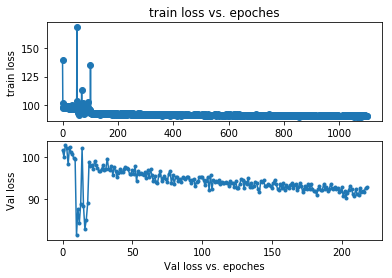

In [34]:
draw(train_loss_2_list, val_loss_2_list)

## 计算R@1

In [38]:
IoU_thresh = [0.1, 0.3, 0.5, 0.7]

In [39]:
def calculate_IoU(i0, i1):
    # calculate temporal intersection over union
    union = (min(i0[0], i1[0]), max(i0[1], i1[1]))
    inter = (max(i0[0], i1[0]), min(i0[1], i1[1]))
    iou = 1.0*(inter[1]-inter[0])/(union[1]-union[0])
    return iou

In [40]:
def compute_IoU_recall_top_n_forreg(iou_thresh, time_mat, time_pre_mat):#top
    correct_num = 0
    for i in range(time_mat.shape[0]):
        gt_start = time_mat[i][0]
        gt_end = time_mat[i][1]
        pred_start = time_pre_mat[i][0]
        pred_end = time_pre_mat[i][1]
        iou = calculate_IoU((gt_start, gt_end),(pred_start, pred_end))
        if iou>=iou_thresh:
            correct_num+=1
    return correct_num

In [41]:
#读取test集
# 读取test数据集
def get_test_dict_for_My_model(path, csv_path):
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    csv=[]
    time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            target = List[4]
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点，前帧后帧取pooling
            target = target.split('_')
            cur_start = float(target[0])
            cur_end = float(target[1])
            middle_time = (cur_start + cur_end)//2
            
            #中间帧
            target_frame_num = int(middle_time/time_length*500)
            target_middle_frame = frame_sum.loc[target_frame_num]
            
            csv.append([target_middle_frame])
            time_list.append([cur_start, cur_end])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                            for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)    
    print(len(batch_seq),len(csv),len(time_list))
    
    return batch_seq, csv, time_list

In [42]:
My_test_seq, My_test_csv, My_test_time_list = get_test_dict_for_My_model(val_path, csv_path)
#x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train

523 523 523


In [46]:
middle_model = LSTM_CNN()
middle_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/new_model_for_1500/394_params.pkl'))
My_model = Change()
My_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2无alignment/513.pkl'))
My_model.eval()
middle_model.eval()                                                                                                                                             

LSTM_CNN(
  (embedding): Embedding(5000, 64)
  (rnn): LSTM(64, 256, num_layers=2, bidirectional=True)
  (f1): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.8)
    (2): ReLU()
  )
  (conv1): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (final_fc): Linear(in_features=256, out_features=128, bias=True)
)

In [47]:
x = Variable(torch.LongTensor(My_test_seq))
batch_size = x.shape[0]
batch_size2 = x.shape[0]
y = Variable(torch.FloatTensor(np.array(My_test_csv)))
My_time_mat = Variable(torch.FloatTensor(np.array(My_test_time_list)))
My_output1 = middle_model(x, y)
score = My_model(My_output1)

# #特征变换
# alignment_mat = score[0]
# l_mat = score[1]
# r_mat = score[2]

# I = torch.eye(batch_size2)
# allone = torch.ones(batch_size2, batch_size2)
# mask = allone - 2 * I

# l_reg = torch.mm(l_mat * I, torch.ones(batch_size2, 1))
# r_reg = torch.mm(r_mat * I, torch.ones(batch_size2, 1))
# offset_pred = torch.cat([l_reg, r_reg], 1)

In [53]:
My_pred_time_mat = score
for iou_thresh in IoU_thresh:
    corrnum = compute_IoU_recall_top_n_forreg(iou_thresh, My_time_mat, My_pred_time_mat-30)
    corr_avg = corrnum*1.0 / My_time_mat.shape[0] 
    print("My_model: R@1 for iou_thresh: %.1f is : %.3f" % (iou_thresh, corr_avg))

My_model: R@1 for iou_thresh: 0.1 is : 0.128
My_model: R@1 for iou_thresh: 0.3 is : 0.082
My_model: R@1 for iou_thresh: 0.5 is : 0.033
My_model: R@1 for iou_thresh: 0.7 is : 0.002


In [49]:
pred_list_time = []
for i in range(My_pred_time_mat.shape[0]):
    begin = My_pred_time_mat[i][0].detach().numpy()
    end = My_pred_time_mat[i][1].detach().numpy()
    pred_list_time.append((begin + end)/2)

In [50]:
list_time = []
for i in range(My_time_mat.shape[0]):
    begin = My_time_mat[i][0].detach().numpy()
    end = My_time_mat[i][1].detach().numpy()
    list_time.append((begin + end)/2)

In [54]:
#计算偏移值
avg = 0.0
offset_list = []
for i in range(len(list_time)):
    offset = list_time[i] - pred_list_time[i]
    offset_list.append(offset)
    avg = avg + offset
avg = avg /len(list_time)

In [52]:
print(avg)

29.976322724531986
